In [3]:
options(dplyr.summarise.inform = FALSE)
library(tidyverse)
library(data.table)

In [4]:
source(paste0(dirname(getwd()),'/map.r'))

#### 0 - prepped biomarkers

In [84]:
go <- fread(paste0(SHARE_DIR, "biomarkers_ex.csv")) 

In [43]:
rna <- go %>% select(contains("rna_")) %>% drop_na(rna_geneset_KEGG_N_GLYCAN_BIOSYNTHESIS)

In [46]:
rna_select <- rna %>% select(contains("rna_geneset"))

Warning message:
“Removed 425 rows containing missing values (`geom_point()`).”


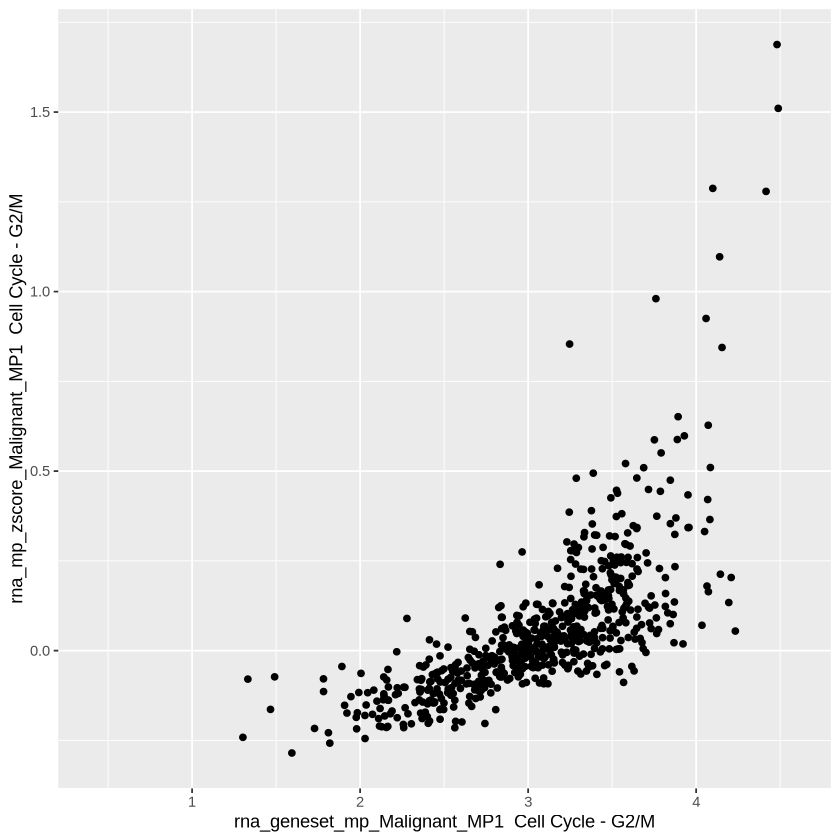

In [25]:
ggplot(rna,
       aes( x = `rna_geneset_mp_Malignant_MP1  Cell Cycle - G2/M`, 
            y = `rna_mp_zscore_Malignant_MP1  Cell Cycle - G2/M`)) + 
  geom_point()

Warning message in geom_abline(a = 0, b = 1, col = "red"):
“Ignoring unknown parameters: `a` and `b`”


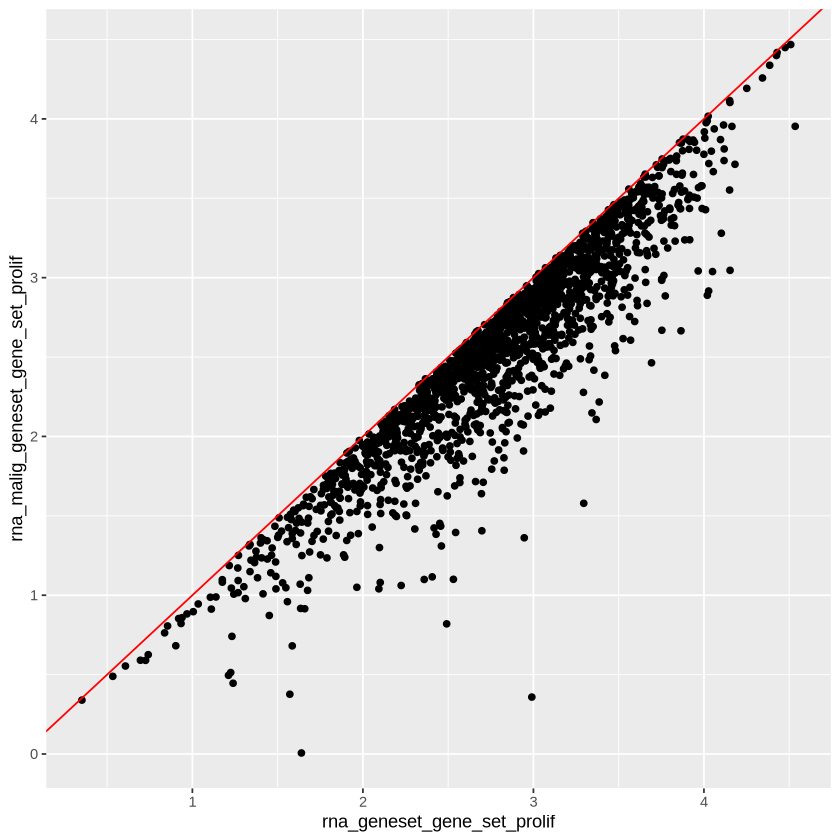

In [27]:
ggplot(go %>% select(contains("prolif")) %>% drop_na(),
       aes( x = rna_geneset_gene_set_prolif, y = rna_malig_geneset_gene_set_prolif)) + geom_point() +
      geom_abline(a = 0, b = 1, col = "red")

#### 2 - CPI analyses

In [196]:
getwd()

[1] "/mnt/bioinfnas/immunocomp/jusset/biomarkers/4_combined_markers"

In [197]:
source(paste0(dirname(getwd()),'/mission_control/stats.r'))

Warning message in file(filename, "r", encoding = encoding):
“cannot open file '/mnt/bioinfnas/immunocomp/jusset/biomarkers/mission_control/stats.r': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [85]:
dim(go)

[1] 6097 3005

In [86]:
library(survival)

In [195]:
#go %>% select(contains("purity"))

In [ ]:
base <-
go %>% 
  filter(clin_anti_pd_treated == 1) %>% 
  transmute( 
    bor = Y_bor, 
    os_event = Y_os_event, 
    os_days = Y_os_days, 
    tmb = purity_tmbPerMb, 
    pre = clin_hasSystemicPreTreatment, 
    prolif = rna_geneset_gene_set_prolif, 
    prolif_malig = rna_malig_geneset_gene_set_prolif, 
    prolif_non_malig = rna_geneset_gene_set_prolif - rna_malig_geneset_gene_set_prolif,   
    tcell =  rna_geneset_gene_set_t_cell_effector,
    tcell_malig = rna_malig_geneset_gene_set_t_cell_effector,
    tcell_non_malig = tcell - tcell_malig,
    tgfb = rna_geneset_KEGG_TGF_BETA_SIGNALING_PATHWAY,
    tgfb_malig = rna_malig_geneset_KEGG_TGF_BETA_SIGNALING_PATHWAY,
    tgfb_non_malig = tgfb - tgfb_malig,
    purity, 
    primary = clin_primaryTumorLocation2) %>% 
    drop_na(prolif)

In [246]:
scale_features <- names(base %>% select(-bor, -os_event, -os_days, -primary))

In [247]:
base <- base %>% mutate_at( scale_features, ~scale(.)) 

In [248]:
oo1 <- coxph( Surv(os_days, os_event) ~ pre + tmb + prolif + tcell + tgfb + purity + primary , data = base)
oo2 <- coxph( Surv(os_days, os_event) ~ pre + tmb + prolif_malig + tcell_non_malig + tgfb_non_malig + purity + primary, data = base)
oo3 <- coxph( Surv(os_days, os_event) ~ pre + tmb + prolif_non_malig + tcell_malig + tgfb_malig + purity + primary, data = base)

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,8,9 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,8,9 ; coefficient may be infinite. ”


#### Compare

In [249]:
extractor <- function(i){
  data.frame(summary(i)$coefficients) %>% 
    rownames_to_column("feature") %>% 
    mutate(high = coef + 2*se.coef., low = coef - 2*se.coef.) %>% 
    filter(!grepl("primary", feature))
}

In [259]:
plotter <- function( i ) {
  ggplot(data=extractor(i), 
             aes(x=feature, y=coef, ymin=low, ymax=high)) +
        geom_pointrange() + 
        geom_hline(yintercept=0, lty=2) +  # add a dotted line at x=1 after flip
        ylim(-1.2,1.2) + 
        coord_flip() +  # flip coordinates (puts labels on y axis)
        xlab("Feature") + ylab("Mean (95% CI)") +
        theme_bw() 
}

In [260]:
options(repr.plot.width = 9,repr.plot.height = 3)

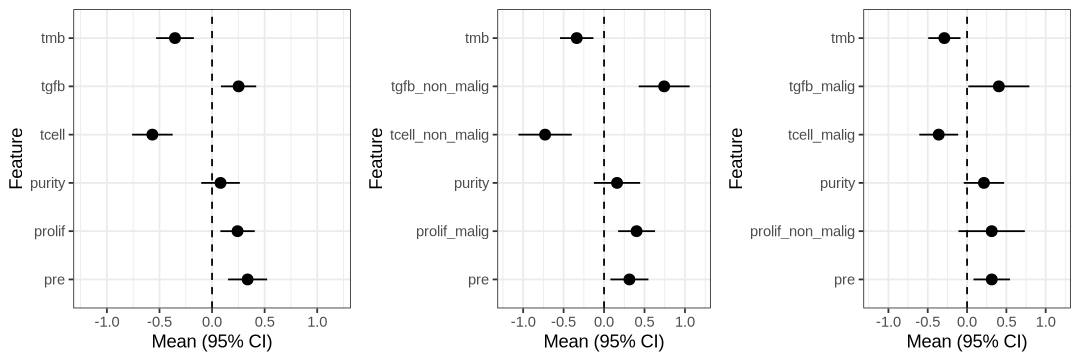

In [261]:
fp <- plotter(oo1)
fp2 <- plotter(oo2)
fp3 <- plotter(oo3)
plot(arrangeGrob(fp, fp2, fp3, ncol = 3))